# Test 5 (paper) - Experimento 3 (PT)

# Ruta de dataset y pesos entrenados

In [27]:
#ubicacion dataset
conjunto_datos = 'customImages/test_5_2/'

#ubicacion pesos del modelo
pesos = 'weights/mask_rcnn_arandano_cfg_test_5_0300.h5' #'arandano_cfg20220907T0914/mask_rcnn_arandano_cfg_0300.h5' 

## Comprobar directorio principal

In [28]:
!pwd && ls

/tf/notebooks/Mask_RCNN-master_matterport_v1.3
LICENSE       images				   mrcnn
MANIFEST.in   mask_rcnn.egg-info		   requirements.txt
README.md     master_test_5.1_val_pred.ipynb	   samples
assets	      master_test_5.2_val_pred.ipynb	   setup.cfg
build	      master_test_5_fase_2_val_pred.ipynb  setup.py
customImages  master_test_6_fase_2_val_pred.ipynb  weights
dist	      master_test_6_val_pred.ipynb


In [29]:
import tensorflow
print(tensorflow.__version__) #2.8.2 

2.11.0-dev20220912


In [30]:
import keras
print(keras.__version__) #2.8.0 

2.10.0


# Importar bibliotecas

In [31]:
# bibliotecas basicas
import os
from os import listdir
import sys
import json
import datetime

# bibliotecas avanzadas 
from xml.etree import ElementTree
import skimage.draw
import cv2
import imgaug

# bibliotecas mask rcnn 
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn import visualize

# biblioteca matplotlib 
import matplotlib.pyplot as plt

# bibliotecas numpy 
import numpy as np
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean

# bibliotecas keras
from tensorflow.keras.preprocessing.image import load_img   #keras.preprocessing.image tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

# ignorar alertas de elementos que seran descontinuados
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline
#plt.show()


# Cargar Dataset

In [32]:
class DatasetArandanos(Dataset):
    
    # la funcion load_dataset es usada para cargar el dataset de entrenamiento y test
    def load_dataset(self, dataset_dir, is_train=True):
        
        # se agrega una clase que se necesita para clasificar, en este caso arandano
        self.add_class("dataset", 1, "arandano")
        
        # se concatena dataset_dir con /images y /annots
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'
        
        # is_train sera Verdadero si se esta entrenando el modelo y Falso si se esta testeando el modelo
        for filename in listdir(images_dir):
            
            # extraer image id
            image_id = filename[:-4] # se usa para omitir los últimos 4 caracteres: '.jpg' (en class_id.jpg)
            
            # si is_train es Verdadero se omiten todas las imágenes con id mayor que e iguales a 11074
            # aproximadamente el 80% del conjunto de datos es para entrenamiento
            
            if is_train and int(image_id) >= 11074 :
                #print("image_id: ", image_id)
                continue
            
            # si is_train no es Verdadero se omiten todas las imágenes con id menores a 11074
            if not is_train and int(image_id) < 11074:
                continue
            
            # se declara la ruta de la imagen y la ruta de las etiquetas 
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            
            # usando la función add_image se pasan image_id, image_path y ann_path para que la 
            # imagen actual se agregue al conjunto de datos para entrenamiento o prueba
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    # funcino usada para extraer bouding boxes desde archivos etiquetados 
    def extract_boxes(self, filename):

        # se puede ver en las imágenes que estan etiquetadas, como se extraen los valores de ancho, alto y bndbox
        
        # <annotation>
        # <size>

        #       <width>640</width>

        #       <height>360</height>

        #       <depth>3</depth>

        # </size>


        # <object>

        #          <name>damage</name>

        #          <pose>Unspecified</pose>

        #          <truncated>0</truncated>

        #          <difficult>0</difficult>


        #          <bndbox>

        #                 <xmin>315</xmin>

        #                 <ymin>160</ymin>

        #                 <xmax>381</xmax>

        #                 <ymax>199</ymax>

        #          </bndbox>

        # </object>
        # </annotation>
        
        # para analizar los archivos .xml
        tree = ElementTree.parse(filename)
        
        # para obtener la raíz del archivo xml
        root = tree.getroot()
        
        # se agregan todas las coordenadas x, y en boxes para todas las instancias de un objeto
        boxes = list()
        
        # se encuentran todos los atributos con el nombre bndbox que existan para cada ground truth en la imagen
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        
        # extraer ancho y alto de la imagen
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        
        # retorna boxes-> list, width-> int y height-> int 
        return boxes, width, height
    
    # this function calls on the extract_boxes method and is used to load a mask for each instance in an image
    # returns a boolean mask with following dimensions width * height * instances

    # esta función llama al método extract_boxes y se usa para cargar una máscara para cada instancia en una imagen 
    # devuelve una máscara booleana con las siguientes dimensiones ancho * alto * instancias
    def load_mask(self, image_id):
        
        # info apunta al image_id actual 
        info = self.image_info[image_id]
        
        # se obtiene la ruta de anotación de image_id que es dataset_dir/annots/image_id.xml 
        path = info['annotation']
        
        # se llama al método extract_boxes (arriba) para obtener bndbox del archivo .xml
        boxes, w, h = self.extract_boxes(path)
        
        # se crea una cantidad de len(boxes) de mascaras de alto 'h' y ancho 'w'
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        
        # se agrega (append) el class_id 1 para arandano en nuestro caso a la variable
        class_ids = list()
        
        # se recorren todos los boxes y generamos máscaras (máscara de bndbox) y class id para cada instancia
        # las máscaras tendrán forma rectangular ya que hemos usado bndboxes para etiquetas
        # por ejemplo: si 2.jpg tiene tres objetos, tendremos las siguientes máscaras y class_ids.

        # 000000000 000000000 000001110 
        # 000011100 011100000 000001110
        # 000011100 011100000 000001110
        # 000000000 011100000 000000000
        #    1         1          1    <- class_ids
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('arandano'))
        
        # retorna mascaras y class_ids como arreglo
        return masks, asarray(class_ids, dtype='int32')
    
    # esta funciones toma el image_id y retorna la ruta de la imagen 
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

# Evaluación del modelo

In [33]:
# se define una configuración de predicción 
class PredictionConfig(Config):
    NAME = "arandano"
    #NUM_CLASSES = 1 + 4
    NUM_CLASSES = 1 + 1
    
    #DETECTION_MIN_CONFIDENCE = 0.85
    DETECTION_MIN_CONFIDENCE = 0.7    
    
    IMAGE_MIN_DIM = 512
    LEARNING_MOMENTUM = 0.8
    RPN_ANCHOR_RATIOS = [0.5, 1, 1.5]
    STEPS_PER_EPOCH = 146
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    USE_MINI_MASK=False
    #USE_MINI_MASK=True    

cfg = PredictionConfig()
cfg.display()



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.8
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

### Evaluacion 1, pesos de entrenamiento con 300 epoch realizada con configuracion para test 5

In [34]:
# evaluate_model se utiliza para calcular mean Average Precision del modelo
def evaluate_model(dataset, model, cfg):
    
    APs = list()
    '''
    Ps = list()
    Rs = list()     
    Os = list()     
    '''
    for image_id in dataset.image_ids:
        
        #image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id)
        
        scaled_image = mold_image(image, cfg)

        sample = expand_dims(scaled_image, 0)

        yhat = model.detect(sample, verbose=0)

        r = yhat[0]

        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        #AP, precisions, recalls, overlaps = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        
        APs.append(AP)
        '''
        Ps.append(precisions)
        Rs.append(recalls)        
        Os.append(overlaps)        
        '''
        maP = mean(APs)
        '''
        mPs = mean(Ps)
        mRs = mean(Rs)
        mOs = mean(Os)
        '''
    #return maP, mPs, mRs, mOs
    return maP

# dataset entrenamiento
train_set = DatasetArandanos()
train_set.load_dataset(conjunto_datos, "train")
train_set.prepare()

# dataset validacion
test_set = DatasetArandanos()
test_set.load_dataset(conjunto_datos, "val")
test_set.prepare()

# crear config
cfg = PredictionConfig()

# definir el modelo
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)

# cargar pesos del modelo
#model.load_weights('your_trained_model_weights.h5', by_name=True) ############################################ 
model.load_weights(pesos, by_name=True)

# evaluar el modelo en el conjunto de datos de entrenamiento
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)

# evaluar el modelo en el conjunto de datos de prueba
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)

'''
# evaluar el modelo en el conjunto de datos de entrenamiento
train_mAP, train_mPs, train_mRs, train_mOs  = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)
print("Train mPs: %.3f" % train_mPs)
print("Train mRs: %.3f" % train_mRs)
print("Train mOs: %.3f" % train_mOs)

# evaluar el modelo en el conjunto de datos de prueba
test_mAP, test_mPs, test_mRs, test_mOs = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)
print("Test mPs: %.3f" % test_mPs)
print("Test mRs: %.3f" % test_mRs)
print("Test mOs: %.3f" % test_mOs)
'''

Train mAP: 0.309
Test mAP: 0.309


'\n# evaluar el modelo en el conjunto de datos de entrenamiento\ntrain_mAP, train_mPs, train_mRs, train_mOs  = evaluate_model(train_set, model, cfg)\nprint("Train mAP: %.3f" % train_mAP)\nprint("Train mPs: %.3f" % train_mPs)\nprint("Train mRs: %.3f" % train_mRs)\nprint("Train mOs: %.3f" % train_mOs)\n\n# evaluar el modelo en el conjunto de datos de prueba\ntest_mAP, test_mPs, test_mRs, test_mOs = evaluate_model(test_set, model, cfg)\nprint("Test mAP: %.3f" % test_mAP)\nprint("Test mPs: %.3f" % test_mPs)\nprint("Test mRs: %.3f" % test_mRs)\nprint("Test mOs: %.3f" % test_mOs)\n'

In [35]:
print("Train mAP: %.3f" % train_mAP)
print("Test mAP: %.3f" % test_mAP)

Train mAP: 0.309
Test mAP: 0.309


# Prediccion de imagen unica

In [36]:
# definir una configuración para el modelo
class PredictionConfig(Config):
    # definir el nombre de la configuración
    NAME = "arandano_pred"
    
    # número de clases (background + kangaroo)
    #NUM_CLASSES = 1 + 4
    NUM_CLASSES = 1 + 1
    
    # número de pasos de entrenamiento por epoch
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    #USE_MINI_MASK=False
    USE_MINI_MASK=True 

    #DETECTION_MIN_CONFIDENCE = 0.85
    DETECTION_MIN_CONFIDENCE = 0.7     
    IMAGE_MIN_DIM = 512
    LEARNING_MOMENTUM = 0.8
    RPN_ANCHOR_RATIOS = [0.5, 1, 1.5]
    STEPS_PER_EPOCH = 146


In [37]:
# cargar configuración de predicción
cfg = PredictionConfig()

# definir el modelo
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)

# cargar pesos del modelo
model_path = pesos    

model.load_weights(model_path, by_name=True)

Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


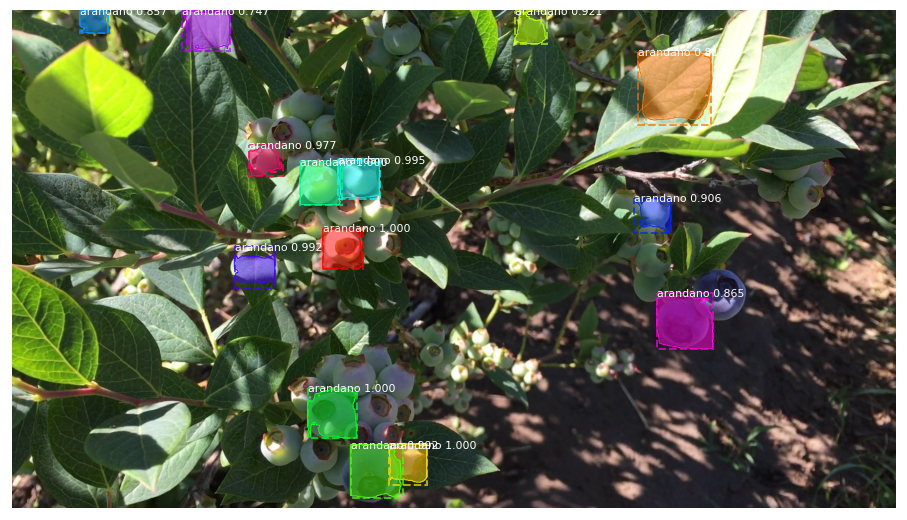

In [38]:
#image = load_img("image_path.jpg")
image = load_img(conjunto_datos + "images/" + "50857.jpg")
image = img_to_array(image)

results = model.detect([image], verbose=1)

#class_names = ['BG', 'arandano', 'arandano2', 'arandano3', 'arandano4']
class_names = ['BG', 'arandano']

r = results[0]

visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names,  r['scores'])

Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


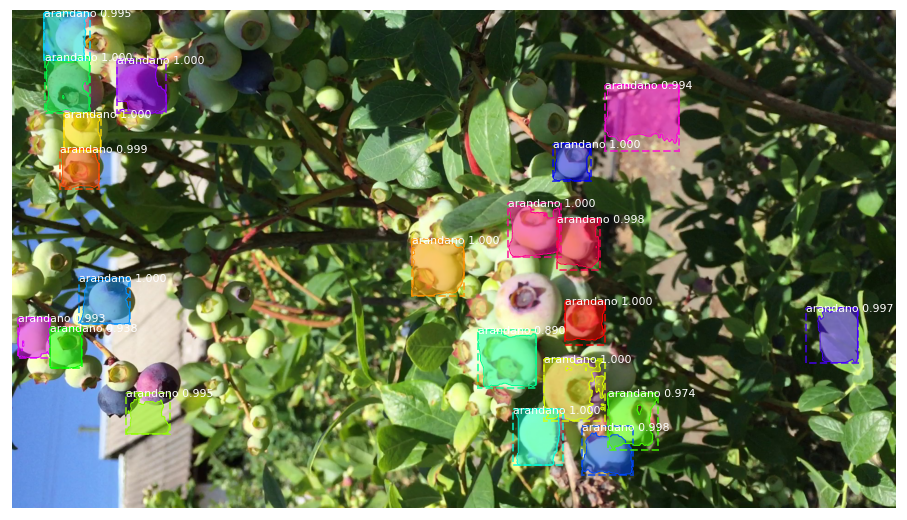

In [39]:
#image = load_img("image_path.jpg")
image = load_img(conjunto_datos + "images/" + "21050.jpg")
image = img_to_array(image)

results = model.detect([image], verbose=1)

#class_names = ['BG', 'arandano', 'arandano2', 'arandano3', 'arandano4']
class_names = ['BG', 'arandano']

r = results[0]

visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names,  r['scores'])

In [40]:
r 

{'rois': array([[ 629, 1203,  725, 1290],
        [  99,   73,  222,  169],
        [ 222,  114,  306,  193],
        [ 755, 1157,  891, 1288],
        [ 105,  229,  222,  336],
        [ 496,  869,  618,  983],
        [ 417, 1079,  535, 1193],
        [ 865, 1090,  987, 1197],
        [ 288, 1176,  369, 1259],
        [ 579,  147,  680,  256],
        [ 299,  105,  386,  190],
        [ 451, 1184,  562, 1279],
        [ 902, 1240, 1008, 1350],
        [ 645, 1725,  764, 1838],
        [ 830,  249,  919,  343],
        [   3,   70,  107,  171],
        [ 160, 1290,  303, 1450],
        [ 667,   14,  753,   84],
        [ 830, 1295,  953, 1405],
        [ 688,   84,  776,  152],
        [ 692, 1013,  818, 1140]], dtype=int32),
 'class_ids': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       dtype=int32),
 'scores': array([0.99999994, 0.9999998 , 0.99999887, 0.9999978 , 0.9999899 ,
        0.99994534, 0.99986076, 0.999773  , 0.99965453, 0.9996389 ,
        0.9

Processing 1 images
image                    shape: (1920, 1080, 3)       min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


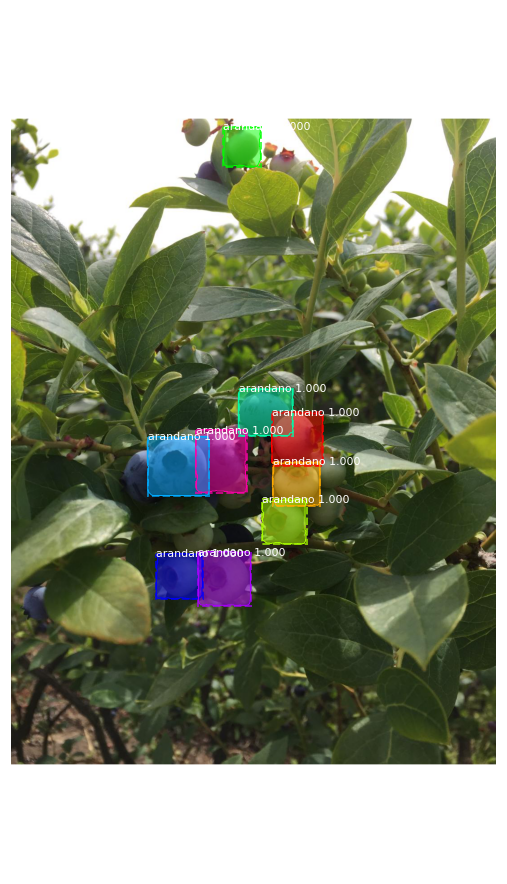

In [41]:
#image = load_img("image_path.jpg")
image = load_img(conjunto_datos + "images/" + "11011.jpg")
image = img_to_array(image)

results = model.detect([image], verbose=1)

#class_names = ['BG', 'arandano', 'arandano2', 'arandano3', 'arandano4']
class_names = ['BG', 'arandano']

r = results[0]

visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names,  r['scores'])

Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


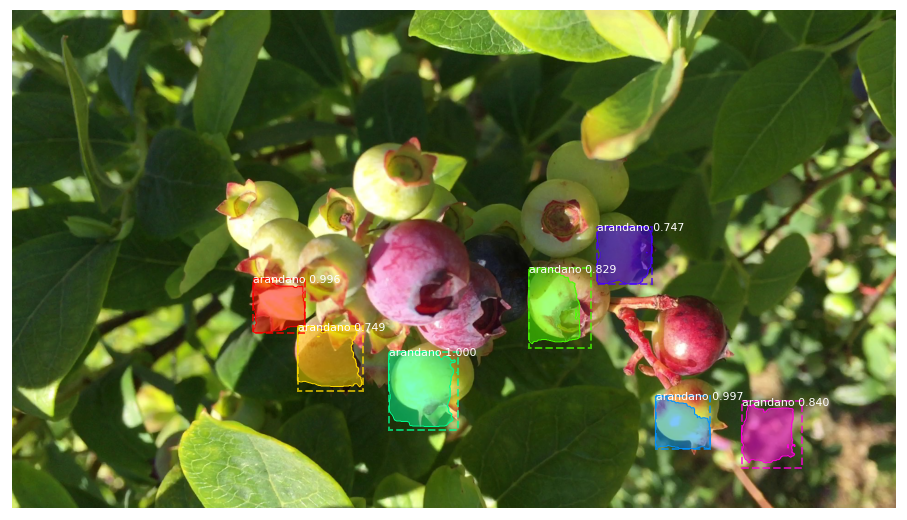

In [42]:
#image = load_img("image_path.jpg")
image = load_img(conjunto_datos + "images/" + "20750.jpg")
image = img_to_array(image)

results = model.detect([image], verbose=1)

#class_names = ['BG', 'arandano', 'arandano2', 'arandano3', 'arandano4']
class_names = ['BG', 'arandano']

r = results[0]

visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names,  r['scores'])

Processing 1 images
image                    shape: (1920, 1080, 3)       min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


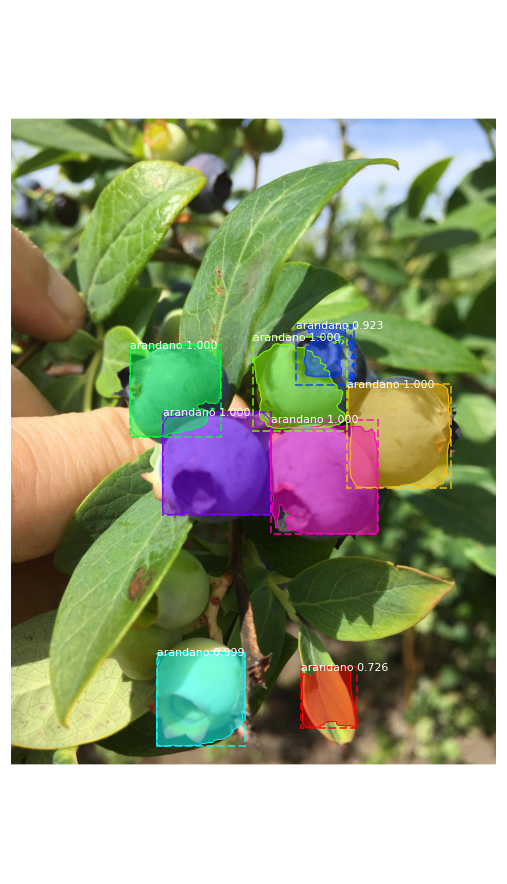

In [43]:
#image = load_img("image_path.jpg")
image = load_img(conjunto_datos + "images/" + "11090.jpg")
image = img_to_array(image)

results = model.detect([image], verbose=1)

#class_names = ['BG', 'Scratch', 'Dent', 'Shatter', 'Dislocation']
#class_names = ['BG', 'arandano', 'arandano2', 'arandano3', 'arandano4']
#class_names = ['arandano', 'BG']
class_names = ['BG', 'arandano']

r = results[0]

visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names,  r['scores'])

Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


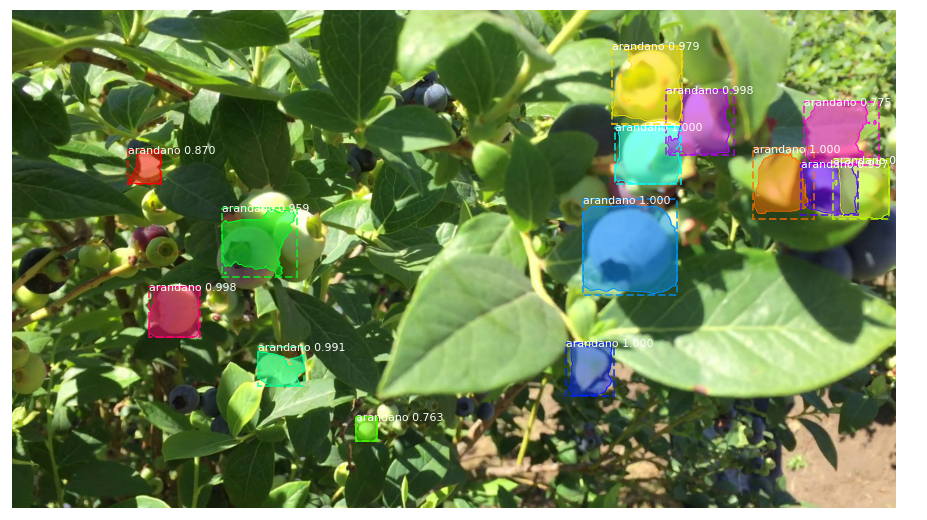

In [44]:
#image = load_img("image_path.jpg")
image = load_img(conjunto_datos + "/images/" + "30851.jpg")
image = img_to_array(image)

results = model.detect([image], verbose=1)

#class_names = ['BG', 'arandano', 'arandano2', 'arandano3', 'arandano4']
class_names = ['BG', 'arandano']

r = results[0]

visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names,  r['scores'])